In [0]:
# importing libraries

import os
import torch
import pickle
import imageio
import itertools
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from time import time, gmtime, strftime
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize

In [2]:
# copying and extracting dataset from drive

import shutil

if not os.path.exists('data'):
    os.makedirs('data')
src_file = 'drive/My Drive/celeb.zip'
dst_file = 'data/celeb.zip'
shutil.copyfile(src_file, dst_file)

import zipfile

zip_ref = zipfile.ZipFile("data/celeb.zip", 'r')
zip_ref.extractall(path='data')
zip_ref.close()

os.remove('data/celeb.zip')

!ls

data  drive  sample_data


In [0]:
# generator and discriminator architectures

class Discriminator(nn.Module):
    def __init__(self, ip=3, hidden=128, op=1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(ip, hidden, 4, 2, 1)
        self.conv2 = nn.Conv2d(hidden, hidden * 2, 4, 2, 1)
        self.conv3 = nn.Conv2d(hidden * 2, hidden * 4, 4, 2, 1)
        self.conv4 = nn.Conv2d(hidden * 4, hidden * 8, 4, 2, 1)
        self.conv5 = nn.Conv2d(hidden * 8, op, 4, 1, 0)
        self.bn1 = nn.BatchNorm2d(hidden)
        self.bn2 = nn.BatchNorm2d(hidden * 2)
        self.bn3 = nn.BatchNorm2d(hidden * 4)
        self.bn4 = nn.BatchNorm2d(hidden * 8)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            self._modules[m].weight.data.normal_(mean, std)
            self._modules[m].bias.data.zero_()

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv5(x)
        x = torch.sigmoid(x)
        return x


class Generator(nn.Module):
    def __init__(self, ip=100, hidden=128, op=3):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(ip, hidden * 8, 4, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(hidden * 8, hidden * 4, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(hidden * 4, hidden * 2, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(hidden * 2, hidden, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(hidden, op, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(hidden * 8)
        self.bn2 = nn.BatchNorm2d(hidden * 4)
        self.bn3 = nn.BatchNorm2d(hidden * 2)
        self.bn4 = nn.BatchNorm2d(hidden)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            self._modules[m].weight.data.normal_(mean, std)
            self._modules[m].bias.data.zero_()

    def forward(self, x):
        x = self.deconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.deconv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.deconv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.deconv5(x)
        x = torch.tanh(x)
        return x

In [0]:
# utility functions

'''
> some utility functions to carry out post processing.
> save results() saves resulting images after each epoch.
> save checkpoint() saves generator and discriminator model after training ends. 
> create_gif() creates a gif of the save_results() images.
> plot() creates the loss plot.
'''

def save_results(epoch, gen=None, show=False, save=False, path='result/output/output_{}.png', device='cuda'):
    if not os.path.exists('result/output'):
        os.makedirs('result/output')

    fixed_noise = Variable(torch.randn((4 * 4, 100)).view(-1, 100, 1, 1).to(device))

    gen.eval()
    test_images = gen(fixed_noise)
    gen.train()

    size_figure_grid = 4
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(4 * 4):
        i = k // 4
        j = k % 4
        ax[i, j].cla()
        ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path.format(epoch))
    if show:
        plt.show()
    else:
        plt.close()


def save_checkpoint(gen=None, disc=None):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(gen, "model/gen.pt")
    torch.save(disc, "model/disc.pt")


def create_gif(path='result/output'):
    images = []
    for files in os.listdir(path):
        images.append(imageio.imread(os.path.join(path, files)))
    imageio.mimsave('result/progress.gif', images, fps=5)


def plot(show=False, save=False, path='result/loss_plot.png'):
    if not os.path.exists('result/losses.pkl'):
        print('Loss pickle not found')
    else:
        with open('result/losses.pkl', 'rb') as f:
            losses = pickle.load(f)

        if not os.path.exists('result'):
            os.makedirs('result')

        x = range(len(losses['disc_loss']))
        y1 = losses['gen_loss']
        y2 = losses['disc_loss']
        plt.plot(x, y1, label='gen_loss')
        plt.plot(x, y2, label='disc_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc=4)
        plt.grid(True)
        plt.tight_layout()
        if save:
            plt.savefig(path)
        if show:
            plt.show()
        else:
            plt.close()

In [0]:
# load the train and test data

'''
> this particular notebook works with MNIST dataset.
> so this function downloads and loads the dataset for training.
'''

class LoadData(Dataset):
    def __init__(self, root='', transform=None):
        super(LoadData, self).__init__()
        self.files = []
        for img in os.listdir(root):
            self.files.append(os.path.join(root, img))
        self.transform = transform

    def __getitem__(self, item):
        img = Image.open(self.files[item])
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.files)

def load_data(batch_size=32, source='data/celeb'):
    train_data = datasets.ImageFolder(os.path.join(source, 'train'),
                          Compose([ToTensor(),
                                             Normalize(mean=[0.5], std=[0.5])
                                            ])
                         )

    test_data = datasets.ImageFolder(os.path.join(source, 'test'),
                         Compose([ToTensor(),
                                            Normalize(mean=[0.5], std=[0.5])
                                           ])
                        )

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)

    test_loader = DataLoader(test_data,
                            batch_size=batch_size,
                            shuffle=False)

    return train_loader, test_loader

In [0]:
# training function for generator and discriminator

def train_gen(gen, disc, optimizer, criterion, x, device):
    gen.zero_grad()

    mini_batch = x.size()[0]
    z = Variable(torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device))
    y = Variable(torch.ones(mini_batch).to(device))

    # forward pass
    gen_op = gen(z)
    disc_op = disc(gen_op).squeeze()
    gen_loss = criterion(disc_op, y)

    # backward pass optimizing only gen's param
    gen_loss.backward()
    optimizer.step()

    return gen_loss.item()


def train_disc(disc, gen, optimizer, criterion, x, device):
    disc.zero_grad()

    # training on real data
    mini_batch = x.size()[0]
    y_real = Variable(torch.ones(mini_batch).to(device))
    x = Variable(x.to(device))

    disc_op = disc(x).squeeze()
    disc_real_loss = criterion(disc_op, y_real)

    # training on fake data
    z = Variable(torch.randn(mini_batch, 100).view(-1, 100, 1, 1).to(device))
    gen_op = gen(z)
    y_fake = Variable(torch.zeros(mini_batch).to(device))

    disc_op = disc(gen_op).squeeze()
    disc_fake_loss = criterion(disc_op, y_fake)

    # backward pass optimizing only disc's param
    disc_loss = disc_real_loss + disc_fake_loss
    disc_loss.backward()
    optimizer.step()

    return disc_loss.item()

In [0]:
# wrapper training function for GAN

'''
> starts the training of generator and discrimator.
> saves the losses of both networks.
> losses used later to plot loss graph.
'''

def train_gan(gen, disc, gen_opt, disc_opt, criterion, device, epoch, train_loader):
    gen_loss = []
    disc_loss = []

    epoch_start = time()
    for img, label in train_loader:
        disc_loss.append(train_disc(disc, gen, disc_opt, criterion, img, device))
        gen_loss.append(train_gen(gen, disc, gen_opt, criterion, img, device))

    end = time() - epoch_start
    print('epoch = {} | disc_loss = {:.6f} | gen_loss = {:.6f} | time elapsed in epoch = {}'.format(epoch + 1,
                                                                                                   torch.mean(torch.FloatTensor(disc_loss)),
                                                                                                   torch.mean(torch.FloatTensor(gen_loss)),
                                                                                                   strftime("%H:%M:%S", gmtime(end))))
    return gen_loss, disc_loss

In [0]:
# hyperparameters

num_epochs = 20
batch_size = 32
lr = 0.0002

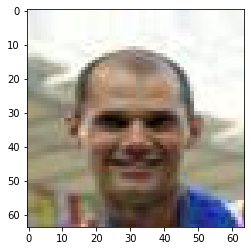

In [9]:
# obtain one batch of training images
import numpy as np

def get_batch(batch_size=32, source='data/celeb'):
    train_loader, test_loader = load_data(batch_size=batch_size, source=source)
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    fig = plt.figure(figsize = (4,4)) 
    ax = fig.add_subplot(111)
    ax.imshow((images[0].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    
get_batch()

In [0]:
# main function

def main():
    print('Training on {}'.format(torch.cuda.get_device_name(0)))
    torch.manual_seed(1)
    device = torch.device('cuda')
    total_loss = {'disc_loss': [], 'gen_loss': []}
    gen = Generator(ip=100, hidden=128, op=3).to(device)
    disc = Discriminator(ip=3, hidden=128, op=1).to(device)
    # gen.weight_init(mean=0.0, std=0.02)
    # disc.weight_init(mean=0.0, std=0.02)
    gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
    disc_opt = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    train_loader, test_loader = load_data(batch_size=batch_size, source='data/celeb')

    print('Dataset loaded. Training starts now....')
    start = time()

    for epoch in range(num_epochs):
        gen_loss, disc_loss = train_gan(gen, disc, gen_opt, disc_opt, criterion, device, epoch, train_loader)
        total_loss['gen_loss'].append(torch.mean(torch.FloatTensor(gen_loss)))
        total_loss['disc_loss'].append(torch.mean(torch.FloatTensor(disc_loss)))

        save_results(epoch, gen=gen, show=False, save=True, path='result/output/output_{}.png', device='cuda')
    save_checkpoint(gen=gen, disc=disc)

    end = time() - start
    print('Training done | Time Elapsed --> {}'.format(strftime("%H:%M:%S", gmtime(end))))

    # saving losses
    with open('result/losses.pkl', 'wb') as f:
        pickle.dump(total_loss, f)

In [13]:
main()

Training on Tesla P100-PCIE-16GB
Dataset loaded. Training starts now....
epoch = 1 | disc_loss = 0.839764 | gen_loss = 3.898379 | time elapsed in epoch = 00:04:27
epoch = 2 | disc_loss = 0.477478 | gen_loss = 4.771756 | time elapsed in epoch = 00:04:26
epoch = 3 | disc_loss = 0.331851 | gen_loss = 5.641393 | time elapsed in epoch = 00:04:25
epoch = 4 | disc_loss = 0.274395 | gen_loss = 6.049836 | time elapsed in epoch = 00:04:25
epoch = 5 | disc_loss = 0.252728 | gen_loss = 6.160390 | time elapsed in epoch = 00:04:25
epoch = 6 | disc_loss = 0.254278 | gen_loss = 6.025185 | time elapsed in epoch = 00:04:26
epoch = 7 | disc_loss = 0.225445 | gen_loss = 6.275041 | time elapsed in epoch = 00:04:26
epoch = 8 | disc_loss = 0.226273 | gen_loss = 6.217601 | time elapsed in epoch = 00:04:27
epoch = 9 | disc_loss = 0.204204 | gen_loss = 6.331687 | time elapsed in epoch = 00:04:27
epoch = 10 | disc_loss = 0.202794 | gen_loss = 6.448558 | time elapsed in epoch = 00:04:26
epoch = 11 | disc_loss = 0

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
create_gif(path='result/output')  # create gif of output images

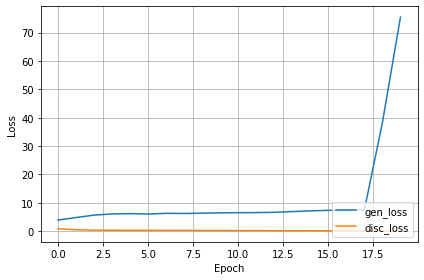

In [14]:
plot(show=True, save=True, path='result/loss_plot.png')

In [0]:
import shutil

for dirs in os.listdir('.'):
    if dirs == 'model' or dirs == 'result':
        shutil.make_archive(dirs, 'zip', dirs)

In [0]:
# copy zip file back to drive

import time
import shutil

start_time = time.time()

src_file = 'model.zip'
dst_file = 'drive/My Drive/model.zip'
shutil.copyfile(src_file, dst_file)

print('Copied Zip File to Drive | Time elapsed --> {} seconds'.format(time.time()-start_time))